## CCSVI Census API Data Pull at Block Group Level

### Overview

The CCSVI project aggregates data and analysis to assess vulnerability.  
The relevant Census data are from American Community Survey 5 year statistics dataset and will  
be used to analyze vulnerability related to demographic, socioeconomic, and related factors.  
The Census API allows data to be "pulled" by constructing a URL consisting of the desired dataset,  
relevant variables, and geographies. We are focused on Census Block Groups for Hawai'i.

### Notes

Variables available for a *Census Data Series* (such as 2023 ACS 5 year) can be viewed by querying the API itself  
with this URL: [https://api.census.gov/data/2023/acs/acs5/variables.html](https://api.census.gov/data/2023/acs/acs5/variables.html)  

Note that this is for **2023**, but the year chosen can be set by altering the URL. That is also true  
of the main data pull in this script.  

Subject tables have fewer variables (fields) and include percentage calculations, averages, etc.  
Subject tables are available for geographic levels above the block group (tract, county, state).  
These can be viewed and queried with a URL like this:  
[https://api.census.gov/data/2023/acs/acs5/subject/variables.html](https://api.census.gov/data/2023/acs/acs5/subject/variables.html)  

The data URL is similar but includes a list of variables and geographic areas to pull.  
  
Example data URL: <span style="color:blue">https://api.census.gov/data/</span><span style="color:red">2023</span><span style="color:green">/acs/acs5</span><span style="color:orange">?get=GEO_ID,B01001_001E,B28011_001E,C16001_001E</span><span style="color:teal">&for=block%20group:*&in=state:15&in=county:*&in=tract:*</span>  

Base component: <span style="color:blue">https://api.census.gov/data/</span>  
Year component: <span style="color:red">2023</span>  
Data series component: <span style="color:green">/acs/acs5</span>  
Get variables component: <span style="color:orange">?get=GEO_ID,B01001_001E,B28011_001E,C16001_001E</span>  
For geography component: <span style="color:teal">&for=block%20group:*&in=state:15&in=county:*&in=tract:*</span>  

The "for" value defines the geographic level, in this case block%20group (spaces aren't allowed in a URL).  
The "in" values define geographic restructions. States are defined by FIPS code (15 for HI).  

Information about FIPS codes: https://www.census.gov/library/reference/code-lists/ansi.html  

### Functionality

This script pulls data from the Census Data API. The basic steps are:  
1. Set up API URL as a set of variables in the script (not to be confused with Census variables)
2. Present URL components to the user and allow them to change them as needed
3. Combine components into complete API URL to pull both <span style="color:cyan">data</span> and <span style="color:magenta">variable descriptions</span> 
4. Pull Census <span style="color:cyan">data</span> and <span style="color:magenta">variable descriptions</span>, and store as CSV files
5. Generate Mobile Geodatabase (based on SQLite) and import CSVs as tables
6. Use <span style="color:magenta">variable descriptions</span> table to assign field aliases to <span style="color:cyan">data</span> table in Mobile Geodatabase

### Why Mobile Geodatabase?

This format was created by ESRI as a more usable format than the File Geodatabase which was basically a folder  
full of numerous proprietary files. The Mobile GDB is a single file and compatible with SQLite, so it is more  
versatile. I have chosen to use this format because it allows assigning field aliases to make Census variables  
readable by humans.  

One downside is feature classes in a MGDB can't be displayed with Python unless data is first converted  
to another format.

**Import libraries for the functions necessary to pull data, process data, and create GUI:**

In [1]:
import os
import pandas as pd

import arcpy
import arcpy.mp as mp

from datetime import datetime
import re
import requests
import numpy as np

import geopandas

import tkinter as tk
from tkinter import scrolledtext
import matplotlib.pyplot as plt



**Define a function to take a folder path or URL and create a clean filename without special characters.**  
**This function works by looking for characters that are not a-z, A-Z, 0-9 and replacing them with underscores _:**

In [2]:
# Function to clean table names
def func_clean_table_name(filename):
    # Replace forbidden characters with underscores
    cleaned_name = re.sub(r'[^a-zA-Z0-9_]', '_', os.path.splitext(filename)[0])
    # Ensure the name doesn't start with a number
    if cleaned_name[0].isdigit():
        cleaned_name = f"_{cleaned_name}"
    return cleaned_name

**Define a function to get input from the user to define the URL for the Census API pull:**

In [3]:
def get_input():
    global census_base_url, census_dataset_url, in_geography, census_variables, shapefile_cbg
    global text_box0, text_box1, text_box2, text_box3, text_box4  # Add these
    census_base_url = text_box0.get("1.0", "end-1c").strip()
    census_dataset_url = text_box1.get("1.0", "end-1c").strip()
    in_geography = text_box2.get("1.0", "end-1c").strip()
    census_variables = text_box3.get("1.0", "end-1c").strip()
    shapefile_cbg = text_box4.get("1.0", "end-1c").strip()
    root.destroy()


**Create a variable with the current directory holding this Jupyter Notebook, to allow locating input and output subfolders:**

In [4]:
# Define current directory that this Notebook is run from
current_dir = os.getcwd()
print(current_dir)

C:\GITHUB\CCSVI\Scripts\Pull_Census_BG_Data


**Create variables and assign default values for census URL components:**

In [5]:
# Default values
census_base_url = "https://api.census.gov/"
census_dataset_url = "data/2023/acs/acs5"
census_variables = "GEO_ID,NAME,B01001_001E,B25003_001E,B01003_001E,C16001_001E,C16002_013E,C16002_014E,B28011_001E,B28011_008E,B25046_001E,B27010_001E,B27010_002E,B27010_017E,B27010_018E,B27010_033E,B27010_034E,B27010_050E,B27010_051E,B27010_066E,B17001_001E,B17001_002E"
in_geography = r"&for=block%20group:*&in=state:15&in=county:*&in=tract:*"

**Create variable and assign default value for Census Block Group shapefile name and location relative to this Notebook:**

In [6]:
shapefile_cbg = r"input\tl_2024_15_bg.shp"


**Generate GUI so that user can review default values and change if necessary:**  
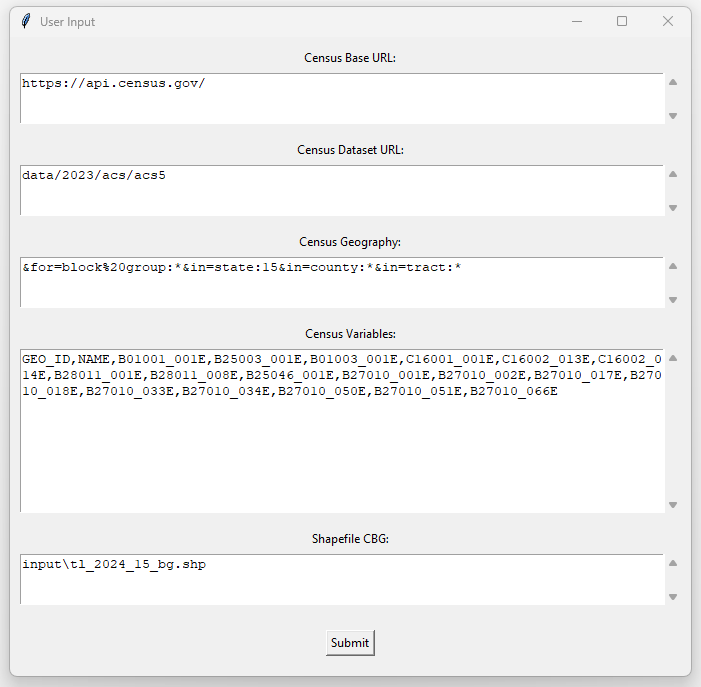

In [7]:
# Create the main window
root = tk.Tk()
root.title("Verify Cennsus API Parameters and Paths")

root.lift()
root.attributes('-topmost', True)
root.after_idle(root.attributes, '-topmost', False)

# Census Base URL
tk.Label(root, text="Census Base URL:").pack(pady=(10, 0))
text_box0 = scrolledtext.ScrolledText(root, width=80, height=2, wrap=tk.WORD)
text_box0.insert(tk.INSERT, census_base_url)
text_box0.pack(padx=10, pady=5)

# Census Dataset URL
tk.Label(root, text="Census Dataset (add /subject for S tables):").pack(pady=(10, 0))
text_box1 = scrolledtext.ScrolledText(root, width=80, height=2, wrap=tk.WORD)
text_box1.insert(tk.INSERT, census_dataset_url)
text_box1.pack(padx=10, pady=5)

# Census Geography
tk.Label(root, text="Census Geography:").pack(pady=(10, 0))
text_box2 = scrolledtext.ScrolledText(root, width=80, height=2, wrap=tk.WORD)
text_box2.insert(tk.INSERT, in_geography)
text_box2.pack(padx=10, pady=5)

# Census Variables
tk.Label(root, text="Census Variables:").pack(pady=(10, 0))
text_box3 = scrolledtext.ScrolledText(root, width=80, height=10, wrap=tk.WORD)
text_box3.insert(tk.INSERT, census_variables)
text_box3.pack(padx=10, pady=5)

# Shapefile CBG
tk.Label(root, text="CBG Shapefile path (relative to this notebook):").pack(pady=(10, 0))
text_box4 = scrolledtext.ScrolledText(root, width=80, height=2, wrap=tk.WORD)
text_box4.insert(tk.INSERT, shapefile_cbg)
text_box4.pack(padx=10, pady=5)

# Submit Button
tk.Button(root, text="Submit", command=get_input).pack(pady=20)

root.mainloop()

**Display the values verified/collected from the user in the previous step:**

In [8]:
# Print values to verify
print("Census Base URL:", census_base_url)
print("Census Dataset URL:", census_dataset_url)
print("Census Geography:", in_geography)
print("Census Variables:", census_variables)
print("Shapefile Name:", shapefile_cbg)

Census Base URL: https://api.census.gov/
Census Dataset URL: data/2023/acs/acs5
Census Geography: &for=block%20group:*&in=state:15&in=county:*&in=tract:*
Census Variables: GEO_ID,NAME,B01001_001E,B25003_001E,B01003_001E,C16001_001E,C16002_013E,C16002_014E,B28011_001E,B28011_008E,B25046_001E,B27010_001E,B27010_002E,B27010_017E,B27010_018E,B27010_033E,B27010_034E,B27010_050E,B27010_051E,B27010_066E,B17001_001E,B17001_002E
Shapefile Name: input\tl_2024_15_bg.shp


**Combine the current directory defined earlier with the shapefile name collected from the user.  
This generates the full path for the CBG polygon shapefile:**

In [9]:
shapefile_cbg_path = os.path.join(current_dir, shapefile_cbg)
print(shapefile_cbg_path)

C:\GITHUB\CCSVI\Scripts\Pull_Census_BG_Data\input\tl_2024_15_bg.shp


**Combine Census Base and Dataset URL components:**

In [10]:
census_combined_url = f"{census_base_url}{census_dataset_url}"
print(census_combined_url)

https://api.census.gov/data/2023/acs/acs5


**Take the census_combined_url that was just generated, and combine with with variables and geography to allow pulling Block Group data:**

In [11]:
cbg_url = f"{census_combined_url}?get={census_variables}{in_geography}"
print(cbg_url)

https://api.census.gov/data/2023/acs/acs5?get=GEO_ID,NAME,B01001_001E,B25003_001E,B01003_001E,C16001_001E,C16002_013E,C16002_014E,B28011_001E,B28011_008E,B25046_001E,B27010_001E,B27010_002E,B27010_017E,B27010_018E,B27010_033E,B27010_034E,B27010_050E,B27010_051E,B27010_066E,B17001_001E,B17001_002E&for=block%20group:*&in=state:15&in=county:*&in=tract:*


**Take the census_combined_url again, and combine with /variables.json to allow pulling a list of variable names and descriptions.**  
**A simple way to view the variables is to visit the URL and replace .json with .html**

In [12]:
census_fields_url = f"{census_combined_url}/variables.json"
print(census_fields_url)

https://api.census.gov/data/2023/acs/acs5/variables.json


**Use the URLs stored previously to generate table names with special characters removed.**  
**Using the URL to generate the table names makes it easy to understand where a table came from:**

In [13]:
#Create cleaned up table names from the URLs 
general_table_name = func_clean_table_name(f"{census_dataset_url}")

fields_table_name = f"{general_table_name}_Fields"

cbg_table_name = func_clean_table_name(f"{census_dataset_url}_CBG")

print(fields_table_name)
print(cbg_url)
print(cbg_table_name)

data_2023_acs_acs5_Fields
https://api.census.gov/data/2023/acs/acs5?get=GEO_ID,NAME,B01001_001E,B25003_001E,B01003_001E,C16001_001E,C16002_013E,C16002_014E,B28011_001E,B28011_008E,B25046_001E,B27010_001E,B27010_002E,B27010_017E,B27010_018E,B27010_033E,B27010_034E,B27010_050E,B27010_051E,B27010_066E,B17001_001E,B17001_002E&for=block%20group:*&in=state:15&in=county:*&in=tract:*
data_2023_acs_acs5_CBG


**Set variables for current time and output folder which includes that time value.**  
**This means every time the program is run, a new output subfolder is created:**

In [14]:
# Create an output subfolder in the same folder as this notebook file, named for current date and time
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
output_folder_name = f"output\output_{current_time}"

# Construct the full path for the new output folder
output_folder_path = os.path.join(current_dir, output_folder_name)

# Create the folder
os.makedirs(output_folder_path, exist_ok=True)

destination_dir = output_folder_path # This is so the destination can be changed easily without messing up the previous code

print(f"Location of this notebook: {current_dir}")
print(f"Destination folder: {destination_dir}")

Location of this notebook: C:\GITHUB\CCSVI\Scripts\Pull_Census_BG_Data
Destination folder: C:\GITHUB\CCSVI\Scripts\Pull_Census_BG_Data\output\output_20250424_141845


**Pull Census variables list (aka fields) and store as a dataframe:**

In [15]:
# Get field listing from json Census URL created previously and put into a data frame so that aliases can be assigned etc.
# Dictionary intermediate step is necessary because the API presents the data as a dictionary rather than simple JSON like the other data

fields_dict = requests.get(census_fields_url).json()

fields_df = pd.DataFrame.from_dict(fields_dict["variables"], orient="index").reset_index()

fields_df.head()

,index,label,concept,predicateType,group,limit,predicateOnly,hasGeoCollectionSupport,attributes,required
0,for,Census API FIPS 'for' clause,Census API Geography Specification,fips-for,N/A,0,True,NaN,NaN,NaN
1,in,Census API FIPS 'in' clause,Census API Geography Specification,fips-in,N/A,0,True,NaN,NaN,NaN
2,ucgid,Uniform Census Geography Identifier clause,Census API Geography Specification,ucgid,N/A,0,True,True,NaN,NaN
3,B24022_060E,Estimate!!Total:!!Female:!!Service occupations...,Sex by Occupation and Median Earnings in the P...,int,B24022,0,NaN,NaN,"B24022_060EA,B24022_060M,B24022_060MA",NaN
4,B19001B_014E,"Estimate!!Total:!!$100,000 to $124,999",Household Income in the Past 12 Months (in 202...,int,B19001B,0,NaN,NaN,"B19001B_014EA,B19001B_014M,B19001B_014MA",NaN


**Pull Census data for CBG level using the previously generated API URL:**

In [16]:
# Get CBG level data with selected fields

cbg_response = requests.get(cbg_url)

cbg_data = cbg_response.json()

cbg_df = pd.DataFrame(cbg_data[1:], columns=cbg_data[0])

cbg_df.head()

,GEO_ID,NAME,B01001_001E,B25003_001E,B01003_001E,C16001_001E,C16002_013E,C16002_014E,B28011_001E,B28011_008E,...,B27010_034E,B27010_050E,B27010_051E,B27010_066E,B17001_001E,B17001_002E,state,county,tract,block group
0,1500000US150010201001,Block Group 1; Census Tract 201; Hawaii County...,1505,485,1505,None,0,21,485,126,...,541,12,266,0,None,None,15,001,020100,1
1,1500000US150010201002,Block Group 2; Census Tract 201; Hawaii County...,495,213,495,None,0,31,213,42,...,218,3,111,7,None,None,15,001,020100,2
2,1500000US150010201003,Block Group 3; Census Tract 201; Hawaii County...,1427,603,1427,None,0,7,603,47,...,691,6,383,0,None,None,15,001,020100,3
3,1500000US150010201004,Block Group 4; Census Tract 201; Hawaii County...,1325,373,1325,None,12,9,373,34,...,538,8,176,22,None,None,15,001,020100,4
4,1500000US150010202021,Block Group 1; Census Tract 202.02; Hawaii Cou...,1170,212,1170,None,0,5,212,40,...,263,0,89,0,None,None,15,001,020202,1


**Generate path to store Census variable list as a CSV file:**

In [17]:
fields_csv_path = os.path.join(destination_dir, f"{fields_table_name}.csv")

fields_df.to_csv(fields_csv_path, index=False, encoding="utf-8")

print(f"CSV file created successfully: {fields_csv_path}")

CSV file created successfully: C:\GITHUB\CCSVI\Scripts\Pull_Census_BG_Data\output\output_20250424_141845\data_2023_acs_acs5_Fields.csv


**Generate path to store CBG data pull as a CSV file**

In [18]:
cbg_csv_path = os.path.join(destination_dir, f"{cbg_table_name}.csv")

cbg_df.to_csv(cbg_csv_path, index=False, encoding="utf-8")

print(f"CSV file created successfully: {cbg_csv_path}")

CSV file created successfully: C:\GITHUB\CCSVI\Scripts\Pull_Census_BG_Data\output\output_20250424_141845\data_2023_acs_acs5_CBG.csv


**Generate path for Mobile Geodatabase and create it using ArcPy library:**

In [19]:
# Generate a filename using the previously generated data set name 
# Also assign destination_dir to the new gdb_dir

gdb_dir = destination_dir
gdb_name = f"{general_table_name}.geodatabase"
#gdb_name = f"{general_table_name}{current_time}.geodatabase"

# Construct the full path for the Mobile Geodatabase using the same Destination Dir as before
gdb_path = os.path.join(gdb_dir, gdb_name)

# Create the Mobile Geodatabase
arcpy.management.CreateMobileGDB(gdb_dir, gdb_name)

print(f"Mobile Geodatabase created at: {gdb_path}")

Mobile Geodatabase created at: C:\GITHUB\CCSVI\Scripts\Pull_Census_BG_Data\output\output_20250424_141845\data_2023_acs_acs5.geodatabase


**Take the previously created CSV files and import to Mobile Geodatabase:**

In [20]:
# Loop through all CSV files in the destination directory, clean up names, and put them into the Geodatabase as tables

for root, dirs, files in os.walk(destination_dir):
    for file in files:
        if file.endswith('.csv'):
            try:
                # Construct the full path to the CSV file
                csv_path = os.path.join(root, file)

                # Generate a valid table name
                table_name = func_clean_table_name(file)

                # Import the CSV into the geodatabase
                arcpy.TableToTable_conversion(
                    in_rows=csv_path,
                    out_path=gdb_path,
                    out_name=table_name
                )
                print(f"Successfully imported {file} as {table_name}.")

            except Exception as e:
                print(f"Error importing {file}: {e}")

print("All CSV files have been imported to the Mobile GDB.")

Successfully imported data_2023_acs_acs5_CBG.csv as data_2023_acs_acs5_CBG.
Successfully imported data_2023_acs_acs5_Fields.csv as data_2023_acs_acs5_Fields.
All CSV files have been imported to the Mobile GDB.


**Find data and variable list tables within the geodatabase. We only have one of each  
but this code can deal with multiple. They are distinguished by filenames.  
Ending in _CBG or other geography marks a table  as data, but ending in  
_Fields marks it as a variable listing table:**

In [21]:
# First step to assign field aliases to field names in all the data tables that were just put into the geodatabase

# Set workspace to the geodatabase path
arcpy.env.workspace = gdb_path

# List all tables in the geodatabase
tables = arcpy.ListTables()

# Separate data and metadata tables
data_tables = [t for t in tables if t.endswith(("_State", "_County","_Tract","_CBG"))]
metadata_tables = [t for t in tables if t.endswith("_Fields")]

print("Data and field name listing tables found")
print(data_tables)
print(metadata_tables)

Data and field name listing tables found
['main.data_2023_acs_acs5_CBG']
['main.data_2023_acs_acs5_Fields']


**Assign the human-readable field aliases from variables list table to data tables:**

In [22]:
# Loop through all data tables and assign field aliases
for data_table in data_tables:
    try:
       
        metadata_table = re.sub(r'(_State|_County|_CBG)$', '_Fields', data_table) # Find the corresponding metadata table to any given state table

        if metadata_table not in metadata_tables:
            print(f"Metadata table not found for {data_table}. Skipping.")
            continue

        print(f"Processing {data_table} with metadata {metadata_table}")

        # Get the actual field names from the metadata table
        metadata_fields = [field.name for field in arcpy.ListFields(metadata_table)]

        # Determine the correct field name for "index"
        index_field = "index_" if "index_" in metadata_fields else "index"
        # Read the mapping of short names to human-readable aliases
        field_name_mapping = {}
        with arcpy.da.SearchCursor(metadata_table, [index_field, "label"]) as cursor:
            for row in cursor:
                field_name_mapping[row[0]] = row[1]

        #print(f"Field name mapping for {metadata_table}: {field_name_mapping}")

        # Update field aliases in the data table
        fields = arcpy.ListFields(data_table)
        for field in fields:
            if field.name in field_name_mapping:
                
                alias0 = field_name_mapping[field.name]
                alias1 = alias0.replace("!!", " ")
                alias = alias1
                #print(f"Modified alias: '{alias1}'")
                
                arcpy.AlterField_management(data_table, field.name, new_field_alias=alias)
                print(f"Updated alias for {field.name} to '{alias}'\n")
            else:
                print(f"Field {field.name} not found in metadata mapping. Skipping alias update.\n")

    except Exception as e:
        print(f"Error processing {data_table}: {e}")

print("Finished processing Mobile Geodatabase and assigning field aliases.")

Processing main.data_2023_acs_acs5_CBG with metadata main.data_2023_acs_acs5_Fields
Field OBJECTID not found in metadata mapping. Skipping alias update.

Updated alias for GEO_ID to 'Geography'

Field NAME not found in metadata mapping. Skipping alias update.

Updated alias for B01001_001E to 'Estimate Total:'

Updated alias for B25003_001E to 'Estimate Total:'

Updated alias for B01003_001E to 'Estimate Total'

Updated alias for C16001_001E to 'Estimate Total:'

Updated alias for C16002_013E to 'Estimate Total: Other languages: Limited English speaking household'

Updated alias for C16002_014E to 'Estimate Total: Other languages: Not a limited English speaking household'

Updated alias for B28011_001E to 'Estimate Total:'

Updated alias for B28011_008E to 'Estimate Total: No Internet access'

Updated alias for B25046_001E to 'Estimate Aggregate number of vehicles available:'

Updated alias for B27010_001E to 'Estimate Total:'

Updated alias for B27010_002E to 'Estimate Total: Under 19

**Check the tables in the geodatabase and generate a list stored as a CSV for checking:**

In [23]:
# List all tables in the geodatabase with field names and aliases nd store as a CSV to check

arcpy.env.workspace = gdb_path
tables = arcpy.ListTables()

# Collect field information for all tables
field_info = []

for table in tables:
    print(f"Processing table: {table}")
    fields = arcpy.ListFields(table)
    for field in fields:
        field_info.append({
            "Table": table,
            "Field Name": field.name,
            "Field Alias": field.aliasName
        })

# Convert to a DataFrame for better visualization

field_info_df = pd.DataFrame(field_info)

# Display the DataFrame in Jupyter Notebook
# field_info_df

#  save to a CSV for reference
output_csv = f"{destination_dir}\\FieldInfo.csv"
field_info_df.to_csv(output_csv, index=False)
print(f"Field information saved to {output_csv}")

Processing table: main.data_2023_acs_acs5_CBG
Processing table: main.data_2023_acs_acs5_Fields
Field information saved to C:\GITHUB\CCSVI\Scripts\Pull_Census_BG_Data\output\output_20250424_141845\FieldInfo.csv


**Import CBG polygon shapefile to Mobile Geodatabase:**

In [24]:
if not os.path.exists(shapefile_cbg_path):
    print(f"Error: The shapefile '{shapefile_cbg}' was not found in '{current_dir}'.")
else:
    arcpy.FeatureClassToGeodatabase_conversion(shapefile_cbg_path, gdb_path)
    print(f"Shapefile found at '{shapefile_cbg_path}' and imported to '{gdb_path}'")
    

Shapefile found at 'C:\GITHUB\CCSVI\Scripts\Pull_Census_BG_Data\input\tl_2024_15_bg.shp' and imported to 'C:\GITHUB\CCSVI\Scripts\Pull_Census_BG_Data\output\output_20250424_141845\data_2023_acs_acs5.geodatabase'


**Generate name of CBG feature class within GDB for use later:**

In [25]:
featureclass_cbg = os.path.splitext(shapefile_cbg)[0]
print(featureclass_cbg)

input\tl_2024_15_bg


**Generate path of CBG feature class within GDB for use later:**

In [26]:
#featureclass_cbg_path = os.path.join(gdb_path, featureclass_cbg)
featureclass_cbg_path = os.path.join(gdb_path, "main.tl_2024_15_bg")
print(featureclass_cbg_path)

C:\GITHUB\CCSVI\Scripts\Pull_Census_BG_Data\output\output_20250424_141845\data_2023_acs_acs5.geodatabase\main.tl_2024_15_bg


**Append all Census variables in variables table to the CBG feature class to create a "flat" dataset:**

In [27]:
# List all tables in the geodatabase
arcpy.env.workspace = gdb_path
tables = arcpy.ListTables()

# Loop through each table and join fields to the feature class
for table in tables:
    if table.endswith("_CBG"):
        print(f"Appending fields from {table} to {featureclass_cbg_path}...")
        
        try:
            arcpy.JoinField_management(
                in_data=featureclass_cbg_path,  # Feature class
                in_field="GEOIDFQ",  # Key field in the feature class
                join_table=os.path.join(gdb_path, table),  # Full table path
                join_field="GEO_ID"  # Key field in the table
            )
            print(f"Successfully joined {table}")
        except Exception as e:
            print(f"Skipping {table} due to error {e}")

print("Join fields completed")

Appending fields from main.data_2023_acs_acs5_CBG to C:\GITHUB\CCSVI\Scripts\Pull_Census_BG_Data\output\output_20250424_141845\data_2023_acs_acs5.geodatabase\main.tl_2024_15_bg...
Successfully joined main.data_2023_acs_acs5_CBG
Join fields completed


**Verify destination_dir and create a temporary shapefile to verify the data:**

In [28]:
print(destination_dir)

C:\GITHUB\CCSVI\Scripts\Pull_Census_BG_Data\output\output_20250424_141845


**Export Mobile Geodatabase feature class to temporary shapefile within output folder.**  
**This will allow it to be displayed to verify that it was created successfully:**

In [29]:
# Export to temporary shapefile
temp_shp = os.path.join(destination_dir,"cbg_temp.shp")
arcpy.conversion.FeatureClassToFeatureClass(
    in_features=featureclass_cbg_path,
    out_path=destination_dir,
    out_name="cbg_temp"
)

<Result 'C:\\GITHUB\\CCSVI\\Scripts\\Pull_Census_BG_Data\\output\\output_20250424_141845\\cbg_temp.shp'>

**Read the temporary shapefile into a geographic dataframe and display it as simple polygons:**

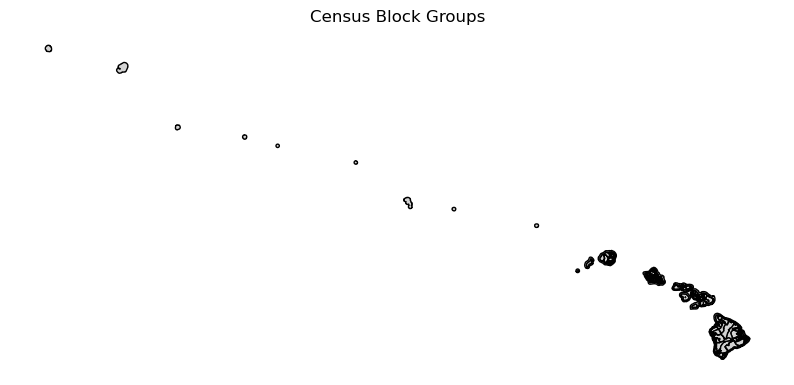

In [30]:
# Read the shapefile exported earlier
gdf = geopandas.read_file(temp_shp)

# Optional: reproject to Web Mercator for better display
gdf = gdf.to_crs(epsg=3857)

# Plot the polygons
gdf.plot(edgecolor='black', facecolor='lightgray', figsize=(10, 10))

plt.axis('off')
plt.title("Census Block Groups")
plt.show()

**Load attribute table from the temporary shapefile into a dataframe and display the "head" or first few rows.  
These are the raw field names, not field aliases that would be visible in the Mobile Geodatabase:**

In [31]:

# Convert GeoDataFrame to DataFrame
df = gdf.drop(columns='geometry')

# Display the first few rows
df.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,GEOIDFQ,NAMELSAD,MTFCC,FUNCSTAT,ALAND,...,B27010_051,B27010_066,B17001_001,B17001_002,state,county,tract,block_grou,st_area_Sh,st_perimet
0,15,003,008948,3,150030089483,1500000US150030089483,Block Group 3,G5030,S,218082.0,...,264,0,None,None,15,3,8948,3,0.000019,0.019027
1,15,003,003414,3,150030034143,1500000US150030034143,Block Group 3,G5030,S,75471.0,...,288,0,None,None,15,3,3414,3,0.000007,0.011633
2,15,003,008952,3,150030089523,1500000US150030089523,Block Group 3,G5030,S,921290.0,...,218,0,None,None,15,3,8952,3,0.000080,0.045011
3,15,003,008947,1,150030089471,1500000US150030089471,Block Group 1,G5030,S,272431.0,...,339,0,None,None,15,3,8947,1,0.000024,0.020576
4,15,003,008948,2,150030089482,1500000US150030089482,Block Group 2,G5030,S,189770.0,...,199,0,None,None,15,3,8948,2,0.000017,0.016577


## The following code is "Phase 2" which calculates new values from existing variables in the Feature Class

#### For flexibility, the calculations will be loaded from an Excel file
#### The .XLSX has 3 fields: Name for new calculated field, Alias for new calc field, and the expression (formula)
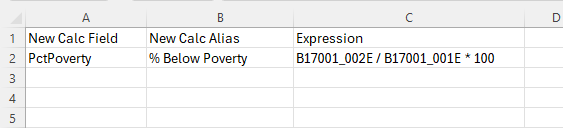

#### Create text variable and calculate path for an input .XLSX file:

In [32]:
calc_excel = r"input\calculations.xlsx"
calc_path = os.path.join(current_dir, calc_excel)
print(calc_path)

C:\GITHUB\CCSVI\Scripts\Pull_Census_BG_Data\input\calculations.xlsx


####
#### Load Excel file starting with line 2 into a data frame:

In [33]:
calc_df = pd.read_excel(calc_path)

# Check the first few rows
print(calc_df.head())

  New_Calc_Field   New_Calc_Alias                       Expression
0     PctPoverty  % Below Poverty  B17001_002E / B17001_001E * 100


#### This function deals with null values in the table by blocking the expression:

In [34]:
def wrap_expression_with_null_check(expr):
    # Find all field names inside !...!
    field_names = re.findall(r"!([^!]+)!", expr)
    null_check = " and ".join([f"{f} is not None" for f in field_names])
    # Wrap the original expression with a conditional null check
    return f"({expr}) if {null_check} else None"

In [37]:
# Loop through each row in the DataFrame
for i, row in calc_df.iterrows():
    calc_field = row["New_Calc_Field"]
    calc_alias = row["New_Calc_Alias"]
    raw_expr = row["Expression"]

    fields_in_expr = re.findall(r'!(\w+)!', raw_expr)
    if len(fields_in_expr) < 2:
        print(f"Skipping invalid expression on row {i}: {raw_expr}")
        continue

    null_checks = ' and '.join([f"{f} is not None" for f in fields_in_expr])
    denom_check = f"{fields_in_expr[1]} != 0"
    safe_expr = f"{raw_expr} if ({null_checks} and {denom_check}) else None"

    arcpy.AddField_management(featureclass_cbg_path, calc_field, "DOUBLE", field_alias=calc_alias)
    arcpy.CalculateField_management(featureclass_cbg_path, calc_field, safe_expr, "PYTHON3")

Skipping invalid expression on row 0: B17001_002E / B17001_001E * 100
